In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
from evojax.util import get_params_format_fn

import os
import time
import numpy as np
import pandas as pd
from scipy import io
import matplotlib.pyplot as plt
import argparse

# choose GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_matmul_precision", "highest")

In [2]:
"""DNN / PINN   """

class PINN(nn.Module):
    """PINNs"""
    n_nodes: int
    def setup(self):
        self.layers = [nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu]
        self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x = inputs[:,0:1], inputs[:,1:2]
        def get_u(t, x):
            f = jnp.hstack([t, x / jnp.pi / 2., t - t_u])
            fs = [f]
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 4 *jnp.pi *f
                if (i%2 != 0):
                    fs.append(f)
            f = jnp.hstack(fs)
            u = self.last_layer(f)
            return u

        u = get_u(t, x)

        # obtain u_t, u_x, u_xx, u_xxxx
        def get_u_dir(get_u, t, x):
            u_t, u_x = jacfwd(get_u)(t, x), jacfwd(get_u, argnums=1)(t, x)
            u_xx = jacfwd(jacfwd(get_u, argnums=1), argnums=1)(t, x)
            u_xxxx = jacfwd(jacfwd(jacfwd(jacfwd(get_u, argnums=1), argnums=1), argnums=1), argnums=1)(t, x)
            return u_t, u_x, u_xx, u_xxxx

        f_dir_vmap = vmap(get_u_dir, in_axes=(None, 0, 0))
        u_t, u_x, u_xx, u_xxxx = f_dir_vmap(get_u, t, x)
        u_t, u_x, u_xx, u_xxxx = u_t[:,:,0], u_x[:,:,0], u_xx[:,:,0,0], u_xxxx[:,:,0,0,0,0]

        # PDE: u_t + v1*u*u_x + v2*u_xx + v3*u_xxxx = 0
        pde = u_t + v1*u*u_x + v2*u_xx + v3*u_xxxx

        # obtain BC/IC indices
        ic, bc = (t == t_l), (x == x_l)  # lower x
        pbc = get_u(t, jnp.ones_like(t)*x_u) - u

        outputs = jnp.hstack([u, u_xx, pde, pbc, ic, bc])
        return outputs


class DNN(nn.Module):
    """DNNs"""
    n_nodes: int
    def setup(self):

        self.layers = [nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu,
                       nn.Dense(self.n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       nn.silu]
        self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        t, x = inputs[:,0:1], inputs[:,1:2]
        def get_u(t, x):
            f = jnp.hstack([t, x / jnp.pi / 2., t - t_u])
            fs = [f]
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 4 *jnp.pi *f
                if (i%2 != 0):
                    fs.append(f)
            f = jnp.hstack(fs)
            u = self.last_layer(f)
            return u

        u = get_u(t, x)

        # obtain u_t, u_x, u_xx, u_xxxx
        def get_u_dir(get_u, t, x):
            u_xx = jacfwd(jacfwd(get_u, argnums=1), argnums=1)(t, x)
            return u_xx

        f_dir_vmap = vmap(get_u_dir, in_axes=(None, 0, 0))
        u_xx = f_dir_vmap(get_u, t, x)[:,:,0,0]

        outputs = jnp.hstack([u, u_xx])
        return outputs

In [3]:
def main(ER, ER_xx, weight_ic, weight_bc, max_lr, exponent, max_iter, seed, gpu):
    
    
    global v1, v2, v3
    
    # parameter
    v1 = 100 / (16)
    v2 = 100 / (16**2)
    v3 = 100 / (16**4)
    
    # read data
    mat_data = io.loadmat('ks_chaotic.mat')
    
    # spatial resolution
    dx = jnp.pi * 2. / 511
    dt = 1. / 250
    
    sim_t = np.repeat(mat_data['t'], 512).reshape(-1,1)
    sim_x = np.tile(mat_data['x'], 251).reshape(-1,1)
    sim_u = mat_data['usol'].reshape(-1,1)
    
    # subset segment
    T = 0.4
    data_X, data_Y = np.hstack([sim_t, sim_x]), sim_u
    data_X, data_Y = data_X[data_X[:,0] <= T], data_Y[data_X[:,0] <= T]
    
    global t_l, t_u, x_l, x_u
    
    t_l, t_u, x_l, x_u = np.min(data_X[:,0]), np.max(data_X[:,0]), np.min(data_X[:,1]), np.max(data_X[:,1])
    
    # split into BC / IC data
    bic = (data_X[:,0] == 0) | (data_X[:,1] == x_l)
    data_X_BIC, data_Y_BIC = data_X[bic], data_Y[bic]
    
    # convert to jnp
    data_X, data_Y, data_X_BIC, data_Y_BIC = jnp.array(data_X), jnp.array(data_Y), jnp.array(data_X_BIC), jnp.array(data_Y_BIC)
    
    
    # choose seed
    seed = seed
    key, rng = random.split(random.PRNGKey(seed))

    # dummy input
    a = random.normal(key, [1,2])

    # initialization call
    n_nodes = 128
    model, model_0 = PINN(n_nodes), DNN(n_nodes)
    params = model.init(key, a)
    num_params, format_params_fn = get_params_format_fn(params)
    # print (num_params)

    # flatten initial params
    params = jax.flatten_util.ravel_pytree(params)[0]

    # update u_0
    params_0 = params

    # minibatch (set #sample)
    BS_ALL = 1000
    BS_BIC = 50

    n_all, n_bic = len(data_X), len(data_X_BIC)

    @jit
    def minibatch(key):
        key1, key2 = key
        batch_all = random.choice(key1, n_all, (BS_ALL - BS_BIC,))
        batch_bic = random.choice(key2, n_bic, (BS_BIC,))
        batch_X = jnp.vstack([data_X[batch_all], data_X_BIC[batch_bic]])
        batch_Y = jnp.vstack([data_Y[batch_all], data_Y_BIC[batch_bic]])
        return (batch_X, batch_Y)

    # loss function
    def eval_loss(params, params_0, inputs, labels):
        pred = model.apply(format_params_fn(params), inputs)
        u, u_xx, pde, pbc, ic, bc = jnp.split(pred, 6, axis=1)
        # stable evolution
        pred0 = model_0.apply(format_params_fn(params_0), inputs)
        u_0, u0_xx = jnp.split(pred0, 2, axis=1)
        if (ER > 0):
            pde = pde + (u - u_0) / ER - v2*(u_xx - u0_xx) / ER_xx  # ER @PDE
        pde_loss = jnp.mean(jnp.square(pde))
        # IC
        ic_e = (labels - u) * ic
        ic_loss = jnp.sum(jnp.square(ic_e)) / ic.sum()
        # BC (periodic)
        bc_e = pbc * bc
        bc_loss = jnp.sum(jnp.square(bc_e)) / bc.sum()
        # stable evolution
        #er_loss = jnp.mean(jnp.square((u - u_0))) / .2
        # mse
        mse = jnp.mean(jnp.square(labels - u))
        rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
        loss = pde_loss + weight_ic* ic_loss + weight_bc* bc_loss #+ er_loss
        return loss, (mse, rl2)

    loss_grad = jax.jit(jax.value_and_grad(eval_loss, has_aux=True))

    # weights update
    @jit
    def update(params, params_0, opt_state, key):
        batch_X, batch_Y = minibatch(key)
        (loss, (mse, rl2)), grad = loss_grad(params, params_0, batch_X, batch_Y)
        updates, opt_state = optimizer.update(grad, opt_state)
        params_0 = params # update u_0
        params = optax.apply_updates(params, updates)
        return params, params_0, opt_state, loss, mse, rl2

    # optimizer
    max_iters = max_iter
    max_lr = max_lr
    lr_scheduler = optax.warmup_cosine_decay_schedule(init_value=max_lr, peak_value=max_lr, warmup_steps=0,
                                                    decay_steps=max_iters, end_value=1e-10, exponent=exponent)
    optimizer = optax.adam(learning_rate=lr_scheduler) # Choose the method
    opt_state = optimizer.init(params)

    """Training"""

    # training iteration
    runtime = 0
    train_iters = 0

    #store = []
    store_nnws = []
    store_nnws.append([0, format_params_fn(params)])

    while (train_iters <= max_iters) and (runtime < 10000):
        # mini-batch update
        start = time.time()
        key1, key2, rng = random.split(rng, 3) # update random generator
        params, params_0, opt_state, loss, mse, rl2 = update(params, params_0, opt_state, (key1, key2))
        end = time.time()
        runtime += (end-start)
        # append weights
        if (train_iters % 2000 == 0):
            print ('iter. = %05d,  time = %03ds,  loss = %.2e  |  mse = %.2e,  rl2 = %.2e'%(train_iters, runtime, loss, mse, rl2))
            # store.append([train_iters, runtime, loss, mse, rl2])
            store_nnws.append([runtime, format_params_fn(params)])
        train_iters += 1

    #store = jnp.array(store)

    """PINN solution"""

    # solution
    inputs, labels = data_X, data_Y
    pred = model.apply(format_params_fn(params), inputs)
    u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
    mse = jnp.mean(jnp.square(labels - u))
    rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
    print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))
    
    return format_params_fn(params), store_nnws

In [4]:
# # run main (ER)
# params = main(ER=0.2, ER_xx=1.5, weight_ic=500, weight_bc=5000,
#               max_lr=1e-3, exponent=0.9, max_iter=200000, seed=20, gpu=0)

In [5]:
# # 5 runs
# params_5, store_nnws_5 = {}, {}
# for seed in [10, 20, 30, 40, 50]:
#     # run main (ER)
#     params, store_nnws = main(ER=0.2, ER_xx=1.5, weight_ic=500, weight_bc=5000,
#                               max_lr=1e-3, exponent=0.9, max_iter=200000, seed=seed, gpu=0)
#     params_5[seed] = params
#     store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 009s,  loss = 1.11e+04  |  mse = 7.87e-01,  rl2 = 1.27e+00
iter. = 02000,  time = 014s,  loss = 6.28e+00  |  mse = 1.17e-01,  rl2 = 4.99e-01
iter. = 04000,  time = 020s,  loss = 7.10e+00  |  mse = 1.16e-01,  rl2 = 4.93e-01
iter. = 06000,  time = 025s,  loss = 2.90e+00  |  mse = 8.23e-02,  rl2 = 4.17e-01
iter. = 08000,  time = 030s,  loss = 1.68e+00  |  mse = 2.80e-02,  rl2 = 2.43e-01
iter. = 10000,  time = 035s,  loss = 1.57e+00  |  mse = 3.40e-02,  rl2 = 2.71e-01
iter. = 12000,  time = 040s,  loss = 7.43e-01  |  mse = 3.06e-02,  rl2 = 2.45e-01
iter. = 14000,  time = 045s,  loss = 6.60e-01  |  mse = 3.43e-02,  rl2 = 2.67e-01
iter. = 16000,  time = 050s,  loss = 2.58e-01  |  mse = 2.68e-02,  rl2 = 2.40e-01
iter. = 18000,  time = 055s,  loss = 2.12e-01  |  mse = 5.18e-02,  rl2 = 3.31e-01
iter. = 20000,  time = 061s,  loss = 1.31e+00  |  mse = 4.24e-02,  rl2 = 3.07e-01
iter. = 22000,  time = 066s,  loss = 5.33e-01  |  mse = 3.23e-02,  rl2 = 2.72e-01
iter. = 24000,  

In [6]:
# # 5 runs (ref)
# ref_params_5, ref_store_nnws_5 = {}, {}
# for seed in [10, 20, 30, 40, 50]:
#     # run main (ER)
#     params, store_nnws = main(ER=0, ER_xx=1.5, weight_ic=500, weight_bc=5000,
#                               max_lr=1e-3, exponent=0.9, max_iter=200000, seed=seed, gpu=0)
#     ref_params_5[seed] = params
#     ref_store_nnws_5[seed] = store_nnws

iter. = 00000,  time = 009s,  loss = 1.11e+04  |  mse = 7.87e-01,  rl2 = 1.27e+00
iter. = 02000,  time = 014s,  loss = 8.18e+00  |  mse = 1.45e-01,  rl2 = 5.56e-01
iter. = 04000,  time = 019s,  loss = 9.03e+00  |  mse = 1.48e-01,  rl2 = 5.56e-01
iter. = 06000,  time = 024s,  loss = 5.20e+00  |  mse = 1.50e-01,  rl2 = 5.63e-01
iter. = 08000,  time = 029s,  loss = 6.92e+00  |  mse = 1.37e-01,  rl2 = 5.36e-01
iter. = 10000,  time = 034s,  loss = 5.47e+00  |  mse = 1.34e-01,  rl2 = 5.39e-01
iter. = 12000,  time = 039s,  loss = 5.38e+00  |  mse = 1.60e-01,  rl2 = 5.61e-01
iter. = 14000,  time = 044s,  loss = 5.46e+00  |  mse = 1.41e-01,  rl2 = 5.42e-01
iter. = 16000,  time = 049s,  loss = 5.43e+00  |  mse = 1.36e-01,  rl2 = 5.39e-01
iter. = 18000,  time = 054s,  loss = 5.28e+00  |  mse = 1.55e-01,  rl2 = 5.72e-01
iter. = 20000,  time = 059s,  loss = 4.62e+00  |  mse = 1.39e-01,  rl2 = 5.56e-01
iter. = 22000,  time = 064s,  loss = 4.68e+00  |  mse = 1.16e-01,  rl2 = 5.16e-01
iter. = 24000,  

In [7]:
import pickle
# save all weight
# pickle.dump(params_5, open('batch5_final_ks', 'wb'))
# pickle.dump(store_nnws_5, open('batch5_hist_ks', 'wb'))
# pickle.dump(ref_params_5, open('batch5_final_ks-ref', 'wb'))
# pickle.dump(ref_store_nnws_5, open('batch5_hist_ks-ref', 'wb'))

# load data
params_5 = pickle.load(open('batch5_final_ks', 'rb'))
store_nnws_5 = pickle.load(open('batch5_hist_ks', 'rb'))
ref_params_5 = pickle.load(open('batch5_final_ks-ref', 'rb'))
ref_store_nnws_5 = pickle.load(open('batch5_hist_ks-ref', 'rb'))

In [8]:
# read data
mat_data = io.loadmat('ks_chaotic.mat')
sim_t = np.repeat(mat_data['t'], 512).reshape(-1,1)
sim_x = np.tile(mat_data['x'], 251).reshape(-1,1)
sim_u = mat_data['usol'].reshape(-1,1)

# subset segment
T = 0.4
data_X, data_Y = np.hstack([sim_t, sim_x]), sim_u
data_X, data_Y = data_X[data_X[:,0] <= T], data_Y[data_X[:,0] <= T]
t_l, t_u, x_l, x_u = np.min(data_X[:,0]), np.max(data_X[:,0]), np.min(data_X[:,1]), np.max(data_X[:,1])

# convert to jnp
data_X, data_Y = jnp.array(data_X), jnp.array(data_Y)
inputs, labels = data_X, data_Y

# parameter
v1 = 100 / (16)
v2 = 100 / (16**2)
v3 = 100 / (16**4)

# model
model = PINN(128)

[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 3.07e-04  RL2 = 2.56e-02


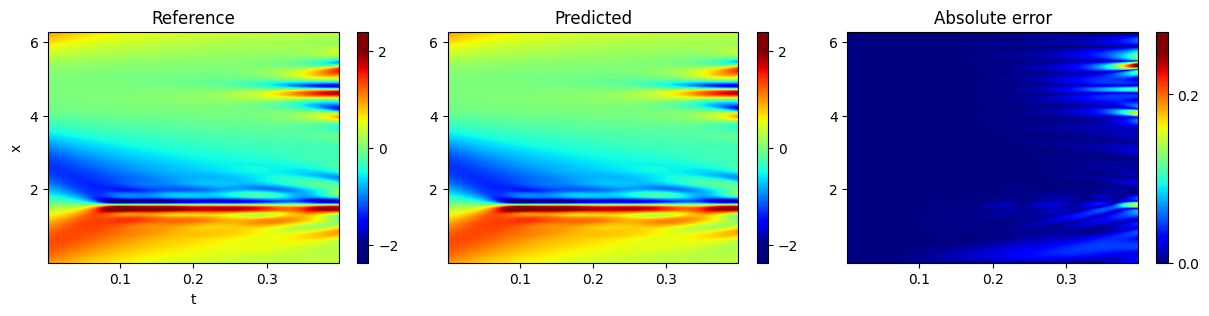

In [12]:
# PINN (final)
params = params_5[20]
pred = model.apply(params, inputs)
u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)

# prediction errors
mse = jnp.mean(jnp.square(labels - u))
rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))

# plot
fig = plt.figure(figsize=(15, 3))
plt.subplots_adjust(wspace=0.1)
# low fi
con_lv = 201
ext = [t_l, t_u, x_l, x_u]
# PINN
ax1 = fig.add_subplot(1,3,1)
plt.contourf(labels.reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=-2, vmax=2);
plt.colorbar(ticks=[-2, 0, 2]) ;plt.title('Reference'); plt.xlabel('t'); plt.ylabel('x'); plt.yticks([2,4,6]);
ax1 = fig.add_subplot(1,3,2)
plt.contourf(u.reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=-2, vmax=2);
plt.colorbar(ticks=[-2, 0, 2]); plt.title('Predicted'); plt.yticks([2,4,6]); 
ax1 = fig.add_subplot(1,3,3)
plt.contourf(abs(u - labels).reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=0, vmax=0.25);
plt.colorbar(ticks=[0, 0.2]); plt.title('Absolute error'); plt.yticks([2,4,6]);

    T = 0-0.4
    [v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 3.07e-04  RL2 = 2.56e-02

In [13]:
# average of 5
rl2s = []
for seed in [10, 20, 30, 40, 50]:
    params = params_5[seed]
    pred = model.apply(params, inputs)
    u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
    # prediction errors
    mse = jnp.mean(jnp.square(labels - u))
    rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
    print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))
    rl2s.append(rl2)
rl2s = np.array(rl2s)
print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  RL2 best = %.2e  ave = %.2e'%(v1, v2, v3, rl2s.min(), rl2s.mean()))

[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 1.28e-03  RL2 = 5.23e-02
[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 3.07e-04  RL2 = 2.56e-02
[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 5.89e-04  RL2 = 3.54e-02
[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 8.70e-04  RL2 = 4.30e-02
[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 7.15e-04  RL2 = 3.90e-02
[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  RL2 best = 2.56e-02  ave = 3.91e-02


In [14]:
# convergence
p_time2sol_5 = {}
for seed in [10, 20, 30, 40, 50]:
    store_nnws = store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        pred = model.apply(params, inputs)
        u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
        # prediction errors
        mse = jnp.mean(jnp.square(labels - u))
        rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
        #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
        p_time2sol.append([runtime, rl2])
    runtime, params = store_nnws[-1]
    pred = model.apply(params, inputs)
    u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
    # prediction errors
    mse = jnp.mean(jnp.square(labels - u))
    rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
    #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol.append([runtime, rl2])    
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    p_time2sol_5[seed] = p_time2sol

[time = 533s] :  RL2 = 5.23e-02
[time = 534s] :  RL2 = 2.56e-02
[time = 537s] :  RL2 = 3.54e-02
[time = 536s] :  RL2 = 4.30e-02
[time = 536s] :  RL2 = 3.90e-02


In [15]:
# convergence (ref)
ref_p_time2sol_5 = {}
for seed in [10, 20, 30, 40, 50]:
    store_nnws = ref_store_nnws_5[seed]
    p_time2sol = []
    for i in range(0, len(store_nnws), 5):
        runtime, params = store_nnws[i]
        pred = model.apply(params, inputs)
        u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
        # prediction errors
        mse = jnp.mean(jnp.square(labels - u))
        rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
        #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
        p_time2sol.append([runtime, rl2])
    runtime, params = store_nnws[-1]
    pred = model.apply(params, inputs)
    u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)
    # prediction errors
    mse = jnp.mean(jnp.square(labels - u))
    rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
    #print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol.append([runtime, rl2])    
    print ('[time = %03ds] :  RL2 = %.2e'%(runtime, rl2))    
    p_time2sol = np.array(p_time2sol)
    ref_p_time2sol_5[seed] = p_time2sol

[time = 519s] :  RL2 = 3.01e-01
[time = 517s] :  RL2 = 2.98e-01
[time = 516s] :  RL2 = 2.98e-01
[time = 516s] :  RL2 = 2.96e-01
[time = 516s] :  RL2 = 2.96e-01


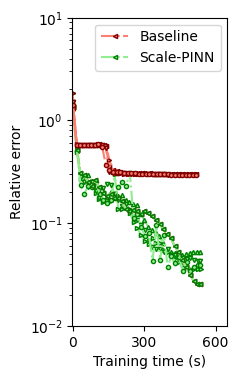

In [17]:
fig = plt.figure(figsize=(2, 4))
makers = ['^', '<', '>', 'v', 'o']
for i, seed in enumerate([10, 20, 30, 40, 50]):
    p_time2sol = p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[i], markersize=3, linestyle='-.');
p_time2sol = p_time2sol_5[20]
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[1], markersize=3, linestyle='-.', label='Baseline');
plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='lightgreen', markeredgecolor='green', marker=makers[1], markersize=3, linestyle='-.', label='Scale-PINN');
for i, seed in enumerate([10, 20, 30, 40, 50]):
    p_time2sol = ref_p_time2sol_5[seed]
    plt.plot(p_time2sol[:,0], p_time2sol[:,1], c='salmon', markeredgecolor='maroon', marker=makers[i], markersize=3, linestyle='-.');
plt.xlabel('Training time (s)'); plt.ylabel('Relative error'); plt.yscale('log'); plt.ylim(1e-2, 10); plt.xlim(-0.5, 650);
plt.xticks([0, 300, 600]); plt.legend();

[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 3.07e-04  RL2 = 2.56e-02


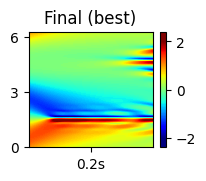

In [24]:
# PINN (final)
params = params_5[20]
pred = model.apply(params, inputs)
u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)

# prediction errors
mse = jnp.mean(jnp.square(labels - u))
rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))

# plot
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 201
ext = [t_l, t_u, x_l, x_u]
# PINN
plt.contourf(u.reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=-2, vmax=2);
plt.colorbar(ticks=[-2, 0, 2]); plt.title('Final (best)'); plt.yticks([0,3,6]); plt.xticks([0.2], ['0.2s']); 

[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 4.17e-02  RL2 = 2.98e-01


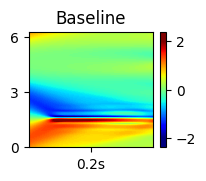

In [25]:
# PINN (ref)
params = ref_params_5[20]
pred = model.apply(params, inputs)
u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)

# prediction errors
mse = jnp.mean(jnp.square(labels - u))
rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))

# plot
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 201
ext = [t_l, t_u, x_l, x_u]
# PINN
plt.contourf(u.reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=-2, vmax=2);
plt.colorbar(ticks=[-2, 0, 2]); plt.title('Baseline'); plt.yticks([0,3,6]); plt.xticks([0.2], ['0.2s']); 

[v1=6.2e+00  v2=3.9e-01  v3=1.5e-03] :  MSE = 9.46e-01  RL2 = 1.42e+00


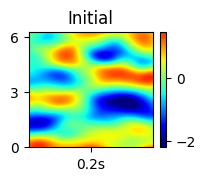

In [26]:
# PINN (initial)
store_nnws = store_nnws_5[50]
runtime, params = store_nnws[0]
pred = model.apply(params, inputs)
u, _, _, _, _, _ = jnp.split(pred, 6, axis=1)

# prediction errors
mse = jnp.mean(jnp.square(labels - u))
rl2 = jnp.linalg.norm(labels - u) / jnp.linalg.norm(labels)
print ('[v1=%.1e  v2=%.1e  v3=%.1e] :  MSE = %.2e  RL2 = %.2e'%(v1, v2, v3, mse, rl2))

# plot
fig = plt.figure(figsize=(2, 1.5))
# low fi
con_lv = 201
ext = [t_l, t_u, x_l, x_u]
# PINN
plt.contourf(u.reshape(-1, 512).T, con_lv, origin='lower', cmap='jet', extent=ext, vmin=-2, vmax=2);
plt.colorbar(ticks=[-2 ,0, 2]); plt.title('Initial'); plt.yticks([0,3,6]); plt.xticks([0.2], ['0.2s']); 